# Haonan Xu HW7 - 2

In [8]:
#!pip install torch

     |████████████████████████████████| 108.1 MB 15.1 MB/s eta 0:00:01


## (b) extarct bird class

In [1]:
#load cifar10 data and select "bird" pictures
import pickle
import numpy as np
cifar_10_dir = '../data/cifar-10-batches-py'
def unpickle(filename):
    with open(filename, 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')
    return data

def load_cifar_10_data(data_dir, negatives=False):
    # training data
    cifar_data = None
    cifar_filenames = []
    cifar_labels = []
    for i in range(1, 6):
        cifar_data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_data = cifar_data_dic['data']
            print(cifar_data.shape)
        else:
            cifar_data = np.vstack((cifar_data, cifar_data_dic['data']))
        cifar_labels += cifar_data_dic['labels']
    cifar_data_dic = unpickle(data_dir + "/test_batch")
    cifar_data = np.vstack((cifar_data, cifar_data_dic['data']))
    cifar_data = cifar_data.reshape((len(cifar_data), 3, 32, 32))
    cifar_data = np.rollaxis(cifar_data, 1, 4)
    cifar_test_labels = cifar_data_dic['labels']
    cifar_labels += cifar_test_labels
    index_list = [i for i,value in enumerate(cifar_labels) if value==2]
    cifar_bird_data = np.array([cifar_data[i] for i in index_list])
    print('cifar_bird_data shape:',cifar_data.shape)
    return cifar_bird_data
cifar_bird_data = load_cifar_10_data(cifar_10_dir)

(10000, 3072)
cifar_bird_data shape: (60000, 32, 32, 3)


## (d) k-means clustering

In [3]:
#k-means cluster
pixel_list = []
for i in cifar_bird_data:
    for j in i:
        for k in j:
            pixel_list.append(k)
pixel_array = np.array(pixel_list)
pixel_list.clear()
row_rand_array = np.arange(pixel_array.shape[0])
np.random.shuffle(row_rand_array)
row_rand = pixel_array[row_rand_array[0:1000000]]
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=4)
cluster_model.fit(row_rand)

KMeans(n_clusters=4)

In [4]:
cluster_model.cluster_centers_

array([[110.33245615, 109.94177918,  83.82365126],
       [ 49.84321746,  50.80720517,  39.15185407],
       [207.81601108, 213.01896121, 212.67378484],
       [157.49581633, 156.97671114, 137.76390141]])

In [6]:
from skimage import color
from skimage import io
cifar_bird_gray_data = color.rgb2gray(cifar_bird_data)

## (e) obtain grayscale

In [9]:
#convert cifar_bird_gray_data to tensor
import torch
cifar_bird_gray_data = cifar_bird_gray_data.reshape(6000,1,32,32)
x  = torch.from_numpy(cifar_bird_gray_data)
x.shape

torch.Size([6000, 1, 32, 32])

In [10]:
labels = cluster_model.fit_predict(cifar_bird_data.reshape(-1,3))

## (f) Deep CNN

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
# define a class for CNN with layers
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            Conv2d(1, 1, kernel_size=5, stride=1, padding=0),
            ReLU(inplace=True),
            Conv2d(1, 1, kernel_size=5, stride=1, padding=0),
            ReLU(inplace=True),#24*24
            MaxPool2d(kernel_size=2, stride=2)#24
        )
        self.linear_layers = Sequential(
            Linear(12*12, 32*32),
            ReLU(inplace=True),
            Linear(32*32,32*32*4),
        )
    # forword
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = x.reshape(1,4,32,32)
        return x

In [25]:
label = labels.reshape(6000,32,32)

In [26]:
# convert train x to tensor
train_x = cifar_bird_gray_data.reshape(6000,1,32,32)[:3000]
train_x  = torch.from_numpy(train_x)

# convert trian y to tensor
train_y = label.astype(int)
train_y = train_y[:3000]
train_y = torch.from_numpy(train_y)
#train_y = train_y.long()
# check shape
train_x.shape, train_y.shape

(torch.Size([3000, 1, 32, 32]), torch.Size([3000, 32, 32]))

In [27]:
# convert validation to tensor
val_x = cifar_bird_gray_data.reshape(6000,1,32,32)[3000:]
val_x  = torch.from_numpy(val_x)

val_y = label.astype(int)
val_y = val_y[3000:]
val_y = torch.from_numpy(val_y)
#val_y = val_y.long()
# check shape
val_x.shape, val_y.shape

(torch.Size([3000, 1, 32, 32]), torch.Size([3000, 32, 32]))

In [28]:
len(val_x)

3000

In [30]:
# define model
torch.set_default_tensor_type(torch.DoubleTensor)
model = Net()
# define optimizer with adam for speed
optimizer = Adam(model.parameters(), lr=0.0001)
# define loss function
criterion = CrossEntropyLoss()

model # summary

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=144, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
  )
)

In [31]:
def train(epoch):
    model.train()
    loss_train = 0
    loss_val = 0
    tr_loss = 0
    # train set
    for i in range(10):
        train1 = torch.unsqueeze(train_x[i], dim=0)
        train2 = torch.unsqueeze(train_y[i], dim=0)
        val1 = torch.unsqueeze(val_x[i], dim=0)
        val2 = torch.unsqueeze(val_y[i], dim=0)
        x_train, y_train = Variable(train1), Variable(train2)
        # validation set
        x_val, y_val = Variable(val1), Variable(val2)

        # zero gradient
        optimizer.zero_grad()

        # predict
        output_train = model(x_train)
        output_val = model(x_val)
        # calculate loss
        loss_train = criterion(output_train, y_train)
        loss_val = criterion(output_val, y_val)
        print('Epoch : ',epoch+1, '\t','Iterator:',i, 'loss :', loss_val)
        # update weights
        loss_train.backward()
        optimizer.step()
        tr_loss = loss_train.item()
        train_losses.append(loss_train)
        val_losses.append(loss_val)
    if epoch%2 == 0:
        # print loss
        print('Epoch : ',epoch+1, 'loss :','\t', loss_val)


In [47]:
# EPOCHS
EPOCHS = 100
train_losses = []
val_losses = []
# training!
for epoch in range(EPOCHS):
    train(epoch)

Epoch :  1 	 Iterator: 0 loss : tensor(1.4414, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 1 loss : tensor(1.4358, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 2 loss : tensor(1.4711, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 3 loss : tensor(1.4794, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 4 loss : tensor(1.5904, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 5 loss : tensor(1.7128, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 6 loss : tensor(1.6319, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 7 loss : tensor(1.5129, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 8 loss : tensor(1.4646, grad_fn=<NllLoss2DBackward>)
Epoch :  1 	 Iterator: 9 loss : tensor(1.5040, grad_fn=<NllLoss2DBackward>)
Epoch :  1 loss : 	 tensor(1.5040, grad_fn=<NllLoss2DBackward>)
Epoch :  2 	 Iterator: 0 loss : tensor(1.4415, grad_fn=<NllLoss2DBackward>)
Epoch :  2 	 Iterator: 1 loss : tensor(1.4359, grad_fn=<NllLoss2DBackward>)
Epoch :  2 	 Iterator: 2

Epoch :  11 	 Iterator: 6 loss : tensor(1.6348, grad_fn=<NllLoss2DBackward>)
Epoch :  11 	 Iterator: 7 loss : tensor(1.5141, grad_fn=<NllLoss2DBackward>)
Epoch :  11 	 Iterator: 8 loss : tensor(1.4667, grad_fn=<NllLoss2DBackward>)
Epoch :  11 	 Iterator: 9 loss : tensor(1.5048, grad_fn=<NllLoss2DBackward>)
Epoch :  11 loss : 	 tensor(1.5048, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 0 loss : tensor(1.4431, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 1 loss : tensor(1.4369, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 2 loss : tensor(1.4734, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 3 loss : tensor(1.4820, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 4 loss : tensor(1.5930, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 5 loss : tensor(1.7190, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 6 loss : tensor(1.6351, grad_fn=<NllLoss2DBackward>)
Epoch :  12 	 Iterator: 7 loss : tensor(1.5142, grad_fn=<NllLoss2DBackward>)
Epoch :  12

Epoch :  22 	 Iterator: 1 loss : tensor(1.4379, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 2 loss : tensor(1.4753, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 3 loss : tensor(1.4842, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 4 loss : tensor(1.5951, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 5 loss : tensor(1.7244, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 6 loss : tensor(1.6377, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 7 loss : tensor(1.5153, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 8 loss : tensor(1.4689, grad_fn=<NllLoss2DBackward>)
Epoch :  22 	 Iterator: 9 loss : tensor(1.5056, grad_fn=<NllLoss2DBackward>)
Epoch :  23 	 Iterator: 0 loss : tensor(1.4446, grad_fn=<NllLoss2DBackward>)
Epoch :  23 	 Iterator: 1 loss : tensor(1.4380, grad_fn=<NllLoss2DBackward>)
Epoch :  23 	 Iterator: 2 loss : tensor(1.4755, grad_fn=<NllLoss2DBackward>)
Epoch :  23 	 Iterator: 3 loss : tensor(1.4844, grad_fn=<NllLoss2DBackward>)

Epoch :  32 	 Iterator: 4 loss : tensor(1.5971, grad_fn=<NllLoss2DBackward>)
Epoch :  32 	 Iterator: 5 loss : tensor(1.7294, grad_fn=<NllLoss2DBackward>)
Epoch :  32 	 Iterator: 6 loss : tensor(1.6401, grad_fn=<NllLoss2DBackward>)
Epoch :  32 	 Iterator: 7 loss : tensor(1.5164, grad_fn=<NllLoss2DBackward>)
Epoch :  32 	 Iterator: 8 loss : tensor(1.4707, grad_fn=<NllLoss2DBackward>)
Epoch :  32 	 Iterator: 9 loss : tensor(1.5063, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 0 loss : tensor(1.4459, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 1 loss : tensor(1.4389, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 2 loss : tensor(1.4773, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 3 loss : tensor(1.4865, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 4 loss : tensor(1.5973, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 5 loss : tensor(1.7299, grad_fn=<NllLoss2DBackward>)
Epoch :  33 	 Iterator: 6 loss : tensor(1.6404, grad_fn=<NllLoss2DBackward>)

Epoch :  42 	 Iterator: 9 loss : tensor(1.5070, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 0 loss : tensor(1.4472, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 1 loss : tensor(1.4397, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 2 loss : tensor(1.4790, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 3 loss : tensor(1.4885, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 4 loss : tensor(1.5992, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 5 loss : tensor(1.7348, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 6 loss : tensor(1.6427, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 7 loss : tensor(1.5174, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 8 loss : tensor(1.4727, grad_fn=<NllLoss2DBackward>)
Epoch :  43 	 Iterator: 9 loss : tensor(1.5071, grad_fn=<NllLoss2DBackward>)
Epoch :  43 loss : 	 tensor(1.5071, grad_fn=<NllLoss2DBackward>)
Epoch :  44 	 Iterator: 0 loss : tensor(1.4473, grad_fn=<NllLoss2DBackward>)
Epoch :  44

Epoch :  53 	 Iterator: 3 loss : tensor(1.4903, grad_fn=<NllLoss2DBackward>)
Epoch :  53 	 Iterator: 4 loss : tensor(1.6010, grad_fn=<NllLoss2DBackward>)
Epoch :  53 	 Iterator: 5 loss : tensor(1.7394, grad_fn=<NllLoss2DBackward>)
Epoch :  53 	 Iterator: 6 loss : tensor(1.6449, grad_fn=<NllLoss2DBackward>)
Epoch :  53 	 Iterator: 7 loss : tensor(1.5184, grad_fn=<NllLoss2DBackward>)
Epoch :  53 	 Iterator: 8 loss : tensor(1.4743, grad_fn=<NllLoss2DBackward>)
Epoch :  53 	 Iterator: 9 loss : tensor(1.5077, grad_fn=<NllLoss2DBackward>)
Epoch :  53 loss : 	 tensor(1.5077, grad_fn=<NllLoss2DBackward>)
Epoch :  54 	 Iterator: 0 loss : tensor(1.4485, grad_fn=<NllLoss2DBackward>)
Epoch :  54 	 Iterator: 1 loss : tensor(1.4406, grad_fn=<NllLoss2DBackward>)
Epoch :  54 	 Iterator: 2 loss : tensor(1.4808, grad_fn=<NllLoss2DBackward>)
Epoch :  54 	 Iterator: 3 loss : tensor(1.4905, grad_fn=<NllLoss2DBackward>)
Epoch :  54 	 Iterator: 4 loss : tensor(1.6012, grad_fn=<NllLoss2DBackward>)
Epoch :  54

Epoch :  63 	 Iterator: 8 loss : tensor(1.4760, grad_fn=<NllLoss2DBackward>)
Epoch :  63 	 Iterator: 9 loss : tensor(1.5083, grad_fn=<NllLoss2DBackward>)
Epoch :  63 loss : 	 tensor(1.5083, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 0 loss : tensor(1.4496, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 1 loss : tensor(1.4414, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 2 loss : tensor(1.4824, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 3 loss : tensor(1.4923, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 4 loss : tensor(1.6029, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 5 loss : tensor(1.7443, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 6 loss : tensor(1.6471, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 7 loss : tensor(1.5193, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 8 loss : tensor(1.4761, grad_fn=<NllLoss2DBackward>)
Epoch :  64 	 Iterator: 9 loss : tensor(1.5083, grad_fn=<NllLoss2DBackward>)
Epoch :  65

Epoch :  74 	 Iterator: 0 loss : tensor(1.4507, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 1 loss : tensor(1.4422, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 2 loss : tensor(1.4839, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 3 loss : tensor(1.4941, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 4 loss : tensor(1.6046, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 5 loss : tensor(1.7486, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 6 loss : tensor(1.6491, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 7 loss : tensor(1.5202, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 8 loss : tensor(1.4777, grad_fn=<NllLoss2DBackward>)
Epoch :  74 	 Iterator: 9 loss : tensor(1.5089, grad_fn=<NllLoss2DBackward>)
Epoch :  75 	 Iterator: 0 loss : tensor(1.4508, grad_fn=<NllLoss2DBackward>)
Epoch :  75 	 Iterator: 1 loss : tensor(1.4422, grad_fn=<NllLoss2DBackward>)
Epoch :  75 	 Iterator: 2 loss : tensor(1.4840, grad_fn=<NllLoss2DBackward>)

Epoch :  84 	 Iterator: 3 loss : tensor(1.4958, grad_fn=<NllLoss2DBackward>)
Epoch :  84 	 Iterator: 4 loss : tensor(1.6062, grad_fn=<NllLoss2DBackward>)
Epoch :  84 	 Iterator: 5 loss : tensor(1.7528, grad_fn=<NllLoss2DBackward>)
Epoch :  84 	 Iterator: 6 loss : tensor(1.6511, grad_fn=<NllLoss2DBackward>)
Epoch :  84 	 Iterator: 7 loss : tensor(1.5210, grad_fn=<NllLoss2DBackward>)
Epoch :  84 	 Iterator: 8 loss : tensor(1.4792, grad_fn=<NllLoss2DBackward>)
Epoch :  84 	 Iterator: 9 loss : tensor(1.5094, grad_fn=<NllLoss2DBackward>)
Epoch :  85 	 Iterator: 0 loss : tensor(1.4519, grad_fn=<NllLoss2DBackward>)
Epoch :  85 	 Iterator: 1 loss : tensor(1.4430, grad_fn=<NllLoss2DBackward>)
Epoch :  85 	 Iterator: 2 loss : tensor(1.4855, grad_fn=<NllLoss2DBackward>)
Epoch :  85 	 Iterator: 3 loss : tensor(1.4959, grad_fn=<NllLoss2DBackward>)
Epoch :  85 	 Iterator: 4 loss : tensor(1.6063, grad_fn=<NllLoss2DBackward>)
Epoch :  85 	 Iterator: 5 loss : tensor(1.7532, grad_fn=<NllLoss2DBackward>)

Epoch :  94 	 Iterator: 6 loss : tensor(1.6529, grad_fn=<NllLoss2DBackward>)
Epoch :  94 	 Iterator: 7 loss : tensor(1.5218, grad_fn=<NllLoss2DBackward>)
Epoch :  94 	 Iterator: 8 loss : tensor(1.4807, grad_fn=<NllLoss2DBackward>)
Epoch :  94 	 Iterator: 9 loss : tensor(1.5100, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 0 loss : tensor(1.4529, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 1 loss : tensor(1.4437, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 2 loss : tensor(1.4869, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 3 loss : tensor(1.4976, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 4 loss : tensor(1.6079, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 5 loss : tensor(1.7573, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 6 loss : tensor(1.6531, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 7 loss : tensor(1.5218, grad_fn=<NllLoss2DBackward>)
Epoch :  95 	 Iterator: 8 loss : tensor(1.4809, grad_fn=<NllLoss2DBackward>)

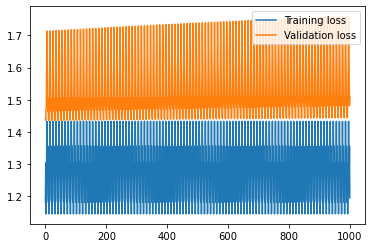

In [48]:
# plot train and val loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

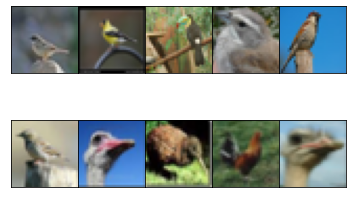

In [49]:
num_plot = 10
f, ax = plt.subplots(2, 5)
count = 0
for m in range(2):
    for n in range(5):
        ax[m, n].imshow(cifar_bird_data[3000+count])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
        count += 1
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

In [50]:
# val_x startfrom 3000
test_picture = []
for i in range(10):
    output_val = None
    output_val = model(torch.unsqueeze(val_x[i], dim=0))
    output_val = output_val.detach().numpy()
    output_val = np.rollaxis(output_val, 1, 4)[0]
    n = np.zeros([32,32])
    for i in range(len(output_val)):
        for j in range(len(output_val[i])):
            n[i][j]=np.argmax(output_val[i][j])
    arr = np.zeros([32,32,3])
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j] = cluster_model.cluster_centers_[int(n[i][j])]
    test_picture.append(arr)

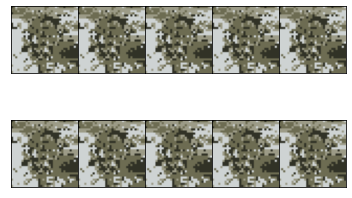

In [51]:
num_plot = 10
f, ax = plt.subplots(2, 5)
count = 0
for m in range(2):
    for n in range(5):
        ax[m, n].imshow(test_picture[count].astype(np.uint8))
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
        count += 1
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()